<a href="https://colab.research.google.com/github/hihunjin/Code-snippet-for-everything/blob/main/copy_and_paste_aug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
%%capture
!git clone https://github.com/conradry/copy-paste-aug

UsageError: Cell magic `%%capture!git` not found.


In [2]:
%%capture
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 19.2 MB/s 
     |████████████████████████████████| 948 kB 38.3 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=d0c70870eef7006fd61baff597ec5d9bdee0d7b4bce96c325bc2936a0bee7003
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
%cd copy-paste-aug

[Errno 2] No such file or directory: 'copy-paste-aug'
/content/copy-paste-aug


In [5]:
%%capture
!wget https://thispersondoesnotexist.com/image -O './image.png'

--2022-02-25 00:13:35--  https://thispersondoesnotexist.com/image
Resolving thispersondoesnotexist.com (thispersondoesnotexist.com)... 104.21.3.164, 172.67.130.241, 2606:4700:3032::ac43:82f1, ...
Connecting to thispersondoesnotexist.com (thispersondoesnotexist.com)|104.21.3.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 442722 (432K) [image/jpeg]
Saving to: ‘./image.png’

./image.png         100%[===================>] 432.35K  1.29MB/s    in 0.3s    

2022-02-25 00:13:36 (1.29 MB/s) - ‘./image.png’ saved [442722/442722]



In [6]:
from PIL import Image
import matplotlib.pyplot as plt
from copy_paste import copy_paste_class
from torch.utils.data import Dataset
import numpy as np

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from copy_paste import CopyPaste


In [30]:
@copy_paste_class
class SomeVisionDataset(Dataset):
    def __init__(self, *args):
        super(SomeVisionDataset, self).__init__(*args)

        self.transforms = A.Compose([
            A.RandomScale(scale_limit=(-0.1, 0.1), p=1), #LargeScaleJitter from scale of 0.1 to 2
            A.PadIfNeeded(130, 130, border_mode=0), #constant 0 border
            A.RandomCrop(100, 100),
            A.HorizontalFlip(p=0.5),
            # pct_objects_paste : int(len(bbox) * pct_objects_paste)만큼만 복붙됨
            # 즉 전체 박스 갯수에서 일부분만 복붙함.
            CopyPaste(blend=True, sigma=8, pct_objects_paste=1, p=1)
            ], bbox_params=A.BboxParams(format="coco")
        )


    def __len__(self):
        return 10

    def load_example(self, idx):
        imarray = np.random.rand(100,100,3) * 255
        masks = np.zeros(shape=(100,100))
        masks[50:80, 20:80] = 1
        masks = masks.astype('uint8')
        # paste
        paste_image = np.asarray(Image.open('image.png').resize(imarray.shape[:2]))

        masks2 = np.zeros(shape=(100,100))
        masks2[30:60, 20:70] = 1
        image_data_dict = {
            'image': imarray.astype('uint8'),
            'masks': [masks],
            'bboxes': [(30, 40, 30, 20, 0)],     # x1, y1, x2, y2, class_id
            'paste_image': paste_image,
            'paste_masks': [masks2.astype('uint8')],
            'paste_bboxes': [(10, 10, 30, 20, 0)],
        }
        transformed_data_dict = self.transforms(**image_data_dict)
        return transformed_data_dict, imarray.astype('uint8'), image_data_dict


================= 0 =================
note
29879
image======


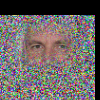

masks======
(100, 100)


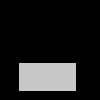

None
None
[(10, 10, 30, 20, 0)]
================= 1 =================
note
29887
image======


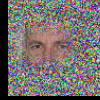

masks======
(100, 100)


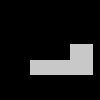

None
None
[(10, 10, 30, 20, 0)]
================= 2 =================
note
29883
image======


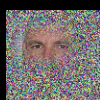

masks======
(100, 100)


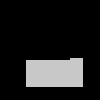

None
None
[(10, 10, 30, 20, 0)]


In [31]:
dataset = SomeVisionDataset()
for i in range(3):
    print("=================", i, "=================")
    out, ar_img, params = dataset.load_example(i)
    # print(out.keys()) == ['image', 'masks', 'bboxes', 'paste_image', 'paste_masks', 'paste_bboxes']
    print('image======')
    display(Image.fromarray(out['image']))
    print('masks======')
    print(out['masks'][0].shape)
    display(Image.fromarray(out['masks'][0]*200, mode='L'))    
    
    # print(out['paste_image']) # == None
    # print(out['paste_masks']) # == None
    # print(out['paste_bboxes'])#  != None
